In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import pywt
from skimage.filters import sobel_h, sobel_v
import glob

def extract_features(df, img_root_col="img_path"):
    feats = []
    for idx, row in df.iterrows():
        path = row[img_root_col]
        if not os.path.isfile(path):
            # skip missing
            continue

        # --- load and gray-scale ---
        img = Image.open(path).convert("L")
        arr = np.array(img, dtype=np.float32) / 255.0

        # --- 1) spatial residual stats (for LSB) ---
        #   compute horizontal & vertical Sobel residuals
        rx = sobel_h(arr)
        ry = sobel_v(arr)
        res = np.stack([rx, ry], axis=0)
        # summary stats: mean & var of each residual band
        stat_spatial = []
        for band in res:
            stat_spatial += [band.mean(), band.var()]

        # --- 2) wavelet subband energies (for IWT) ---
        # 2-level Haar DWT
        coeffs = pywt.wavedec2(arr, wavelet='haar', level=2)
        # coeffs = [cA2, (cH2,cV2,cD2), (cH1,cV1,cD1)]
        stat_wave = []
        # skip the final approximation (cA2), focus on detail bands
        for level in coeffs[1:]:
            for subband in level:
                stat_wave.append(np.sum(subband**2) / subband.size)

        # --- assemble ---
        feature_vector = stat_spatial + stat_wave
        feats.append({
            "idx": idx,
            **{f"f{i}": v for i, v in enumerate(feature_vector)},
            "label": row["label"]
        })

    feat_df = pd.DataFrame(feats).set_index("idx")
    return feat_df

In [5]:
import pandas as pd
import glob
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    accuracy_score,
    classification_report,
)

# 1) Load your stego CSV and filter
STEGO_CSV = "./csv/stego_final.csv"
df = pd.read_csv(STEGO_CSV)
df = df[df.method.isin(["lsb","iwt"])].copy()
df["label"]    = df["method"]
df["img_path"] = df["stego_path"]

# 2) Build your cover-image DataFrame
cover_paths = glob.glob(os.path.join("./initial", "*.*"))
cover_df = pd.DataFrame({"img_path": cover_paths})
cover_df["label"] = "none"

# 3) Concatenate to get full dataset
full_df = pd.concat([df[["img_path","label"]], cover_df], ignore_index=True)

# 4) Extract features (assumes extract_features returns a DataFrame with ['img_path','label', feat1,feat2,...])
feat_df = extract_features(full_df)
print("Extracted feature shape:", feat_df.shape)

# 5) Prepare X (features) and y (true labels)
feature_cols = [c for c in feat_df.columns if c not in ("img_path","label")]
X       = feat_df[feature_cols].values
y_true  = feat_df["label"].values

# 6) (Optional) PCA to 50 dims
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X)

# 7) Fit K-means with as many clusters as unique labels
n_clusters = len(pd.unique(y_true))
kmeans    = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, random_state=42)
clusters  = kmeans.fit_predict(X_reduced)
feat_df["cluster"] = clusters

# 8) Evaluate
sil_score = silhouette_score(X_reduced, clusters)
ari_score = adjusted_rand_score(y_true, clusters)

# 9) Map each cluster to its most common true label
mapping = {}
for cl in range(n_clusters):
    mapping[cl] = feat_df.loc[feat_df.cluster == cl, "label"].value_counts().idxmax()
feat_df["cluster_label"] = feat_df["cluster"].map(mapping)

acc_score = accuracy_score(y_true, feat_df["cluster_label"])

# 10) Print results
print(f"Silhouette Score:      {sil_score:.4f}")
print(f"Adjusted Rand Index:   {ari_score:.4f}")
print(f"Clustering Accuracy:   {acc_score:.4f}\n")
print("Detailed classification report:")
print(classification_report(y_true, feat_df["cluster_label"]))


Extracted feature shape: (3897, 11)


ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=10 with svd_solver='covariance_eigh'

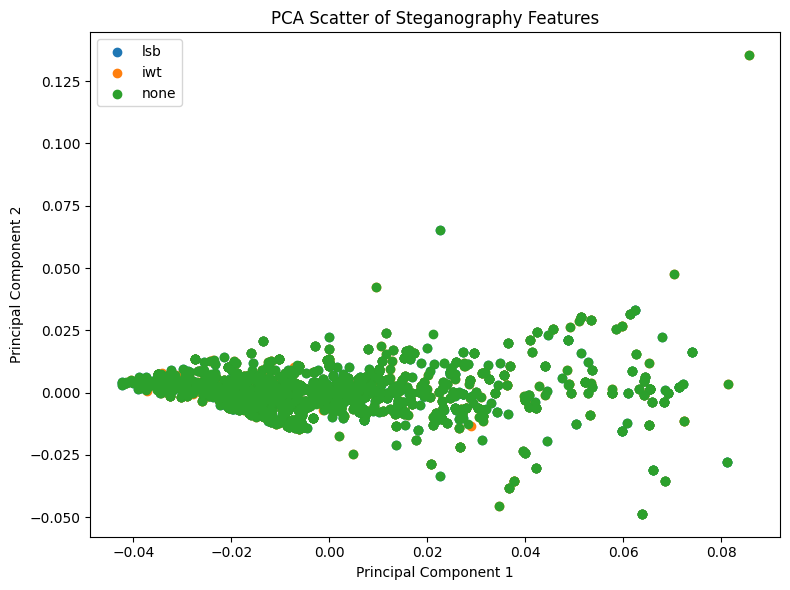

In [7]:
import matplotlib.pyplot as plt
# ——— 2) Extract the feature matrix ———
X = feat_df[[f"f{i}" for i in range(10)]].values  # shape (n_samples, 10)

# ——— 3) PCA reduction to 2D ———
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)  # shape (n_samples, 2)

# ——— 4) Build a small DataFrame for plotting ———
pca_df = pd.DataFrame({
    'PC1': X_reduced[:, 0],
    'PC2': X_reduced[:, 1],
    'label': feat_df['label'].values
})

# ——— 5) Scatter plot ———
plt.figure(figsize=(8, 6))
for lbl in pca_df['label'].unique():
    subset = pca_df[pca_df['label'] == lbl]
    plt.scatter(subset['PC1'], subset['PC2'], label=lbl)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter of Steganography Features')
plt.legend()
plt.tight_layout()
plt.show()

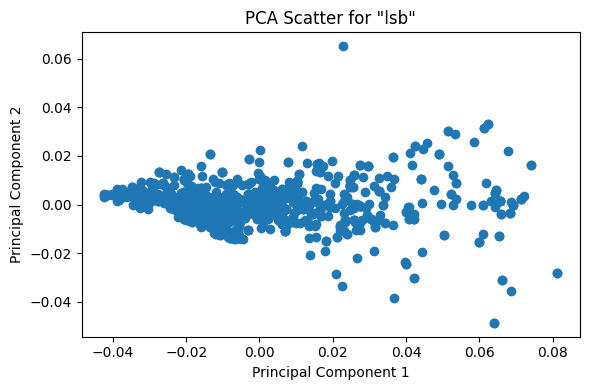

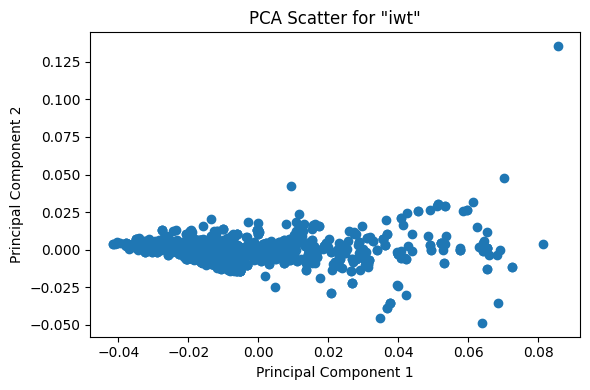

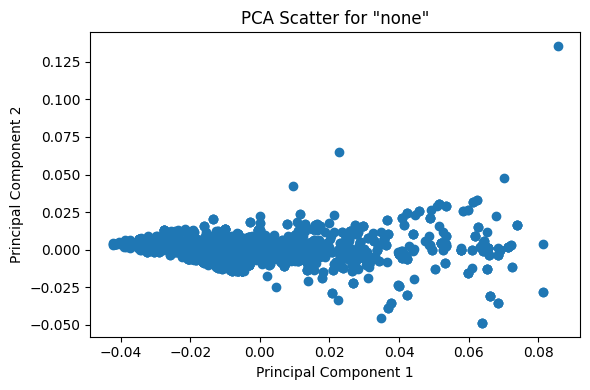

In [8]:
# ——— 3) Plot separate scatter for each class ———
for lbl in pca_df['label'].unique():
    subset = pca_df[pca_df['label'] == lbl]
    plt.figure(figsize=(6, 4))
    plt.scatter(subset['PC1'], subset['PC2'])
    plt.title(f'PCA Scatter for "{lbl}"')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.show()